## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor

sns.set()

In [14]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [15]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [16]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_ve_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno        VIX  EMV-ID  \
0    2010-01-01    0.000000  2044.23        695125.0  22.543626    2.01   
1    2010-01-02    4.256365  2044.23        695125.0  22.171185    0.00   
2    2010-01-03    0.794545  2044.23        695125.0  21.143152    1.15   
3    2010-01-04    0.787899  2044.23        705000.0  20.040000    1.22   
4    2010-01-05    0.601027  2021.21        690000.0  19.350000    0.95   
...         ...         ...      ...             ...        ...     ...   
3648 2019-12-27    4.003614  3281.40        995000.0  13.430000    0.00   
3649 2019-12-28    2.090121  3294.05        995000.0  14.351756    0.00   
3650 2019-12-29    0.539108  3294.05        995000.0  14.946538    4.26   
3651 2019-12-30    1.815513  3294.05        991000.0  14.820000    0.97   
3652 2019-12-31    1.871355  3277.14        975000.0  13.780000    1.54   

         EPU  
0     174.55  
1     119.52  
2     216.95  
3     150.35  
4     151.16  
...      ...  
3648  127.92  
3649  123.10  
3650  245.14  
3651  101.31  
3652  105.75  

[3653 rows x 7 columns]

---

## Desarrollo del modelo RF

In [18]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [19]:
df_stats=df

In [20]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [21]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(1093, 1)
(1093, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19877062188139466
MAE is : 0.31945240093666954
RMSE is : 0.4458369902569712
MAPE is : 15.909893760016322
Evaluation metric results:
MSE is : 1.0676053957906444
MAE is : 0.8023038625460919
RMSE is : 1.0332499193276738
MAPE is : 45.18207469959405
(1093, 1)
(1093, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.19249663277815687
MAE is : 0.31852656829035025
RMSE is : 0.43874438204740224
MAPE is : 15.880737068752238
Evaluation metric results:
MSE is : 1.0747057108964266
MAE is : 0.7981581339077496
RMSE is : 1.0366801391443876
MAPE is : 44.73175035039641
(1093, 1)
(1093, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18639147419375812
MAE is : 0.31846578480872306
RMSE is : 0.4317307890268635
MAPE is : 16.023664826740518
Evaluation metric results:
MSE is : 1.0494196305574939
MAE is : 0.7931008002218187
RMSE is : 1.024411846162223
MAPE is : 44.9644967696087
(1093, 1)
(1093, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.18612731487904371
MAE is : 0.31659096576462353
RMSE is : 0.4314247499611534
MAPE is : 15.905972127523047
Evaluation metric results:
MSE is : 1.059854664183604
MAE is : 0.8018389516479394
RMSE is : 1.0294924303673165
MAPE is : 45.52669863388086
(1093, 1)
(1093, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1093, 1)
len PREDICT:  (1093, 1)
Evaluation metric results:
MSE is : 0.1850911777788724
MAE is : 0.3164186533756734
RMSE is : 0.4302222423107299
MAPE is : 15.867482494424562
Evaluation metric results:
MSE is : 1.0649611427709478
MAE is : 0.8024740561505536
RMSE is : 1.031969545466797
MAPE is : 45.44728398520472
(1091, 1)
(1091, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.20322853741410613
MAE is : 0.325465397780032
RMSE is : 0.4508087592473178
MAPE is : 16.223979252143714
Evaluation metric results:
MSE is : 1.3751303685513105
MAE is : 0.923140579428414
RMSE is : 1.1726595279753245
MAPE is : 54.04604827723488
(1091, 1)
(1091, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19371276507714813
MAE is : 0.32163897557856674
RMSE is : 0.44012812347900254
MAPE is : 16.195644483161413
Evaluation metric results:
MSE is : 1.358448926042526
MAE is : 0.918425909410984
RMSE is : 1.1655251717755932
MAPE is : 53.711429874877716
(1091, 1)
(1091, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.1911980610807228
MAE is : 0.32020105886555555
RMSE is : 0.43726200507330015
MAPE is : 16.12320615984662
Evaluation metric results:
MSE is : 1.4242554017253144
MAE is : 0.9405694798723173
RMSE is : 1.1934217199822175
MAPE is : 55.35497965297165
(1091, 1)
(1091, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.19268689144467982
MAE is : 0.3200005567092809
RMSE is : 0.43896115026808447
MAPE is : 16.02796745870841
Evaluation metric results:
MSE is : 1.3541688478772356
MAE is : 0.9182011976248043
RMSE is : 1.1636876075121
MAPE is : 53.87183186866896
(1091, 1)
(1091, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1091, 1)
len PREDICT:  (1091, 1)
Evaluation metric results:
MSE is : 0.18786185833376307
MAE is : 0.3172597387581131
RMSE is : 0.43343033850177476
MAPE is : 15.88160330804737
Evaluation metric results:
MSE is : 1.3341018727574385
MAE is : 0.9132032324491473
RMSE is : 1.1550332777705752
MAPE is : 53.62930261312767
(1089, 1)
(1089, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.20190288514458912
MAE is : 0.3260612162339196
RMSE is : 0.4493360492377494
MAPE is : 16.34361587684968
Evaluation metric results:
MSE is : 1.440665005810028
MAE is : 0.9295292075113832
RMSE is : 1.2002770537713483
MAPE is : 53.9511831671863


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(1089, 1)
(1089, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19697058159381575
MAE is : 0.32355881219834737
RMSE is : 0.4438136789169705
MAPE is : 16.304990132411188
Evaluation metric results:
MSE is : 1.5207104518179797
MAE is : 0.9548446805329116
RMSE is : 1.233170893192821
MAPE is : 55.485801662469036
(1089, 1)
(1089, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.19080464906402247
MAE is : 0.31833046968555967
RMSE is : 0.43681191497488076
MAPE is : 15.995847382171355
Evaluation metric results:
MSE is : 1.4122754981183137
MAE is : 0.9224292118357313
RMSE is : 1.1883919799957898
MAPE is : 53.494710525137066
(1089, 1)
(1089, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.18952057288473811
MAE is : 0.31822240692789716
RMSE is : 0.43533960638188907
MAPE is : 15.99064922628884
Evaluation metric results:
MSE is : 1.5526768154468176
MAE is : 0.9617944742368447
RMSE is : 1.2460645310122656
MAPE is : 55.97013085430894
(1089, 1)
(1089, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1089, 1)
len PREDICT:  (1089, 1)
Evaluation metric results:
MSE is : 0.18873937916811936
MAE is : 0.31790231666657914
RMSE is : 0.43444145654865785
MAPE is : 15.982042479342997
Evaluation metric results:
MSE is : 1.4987939938051231
MAE is : 0.9473368564160554
RMSE is : 1.2242524224215867
MAPE is : 55.17099426285059
(1088, 1)
(1088, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.20624869967269904
MAE is : 0.32828686459921197
RMSE is : 0.45414612149912614
MAPE is : 16.52150230175924
Evaluation metric results:
MSE is : 1.2924327410017895
MAE is : 0.8855331711493375
RMSE is : 1.13685211923178
MAPE is : 50.96798952775304
(1088, 1)
(1088, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.19601267007363354
MAE is : 0.3204551197984217
RMSE is : 0.44273318158190217
MAPE is : 16.09245649090919
Evaluation metric results:
MSE is : 1.5633514411019183
MAE is : 0.9601774273663297
RMSE is : 1.2503405300564796
MAPE is : 55.62711237618325
(1088, 1)
(1088, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.192458440668407
MAE is : 0.3194570928285931
RMSE is : 0.43870085555923755
MAPE is : 15.967174489049398
Evaluation metric results:
MSE is : 1.5998397479398303
MAE is : 0.9650718373007384
RMSE is : 1.264847717292414
MAPE is : 56.111253562260224
(1088, 1)
(1088, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.1924304785348109
MAE is : 0.3211585206436964
RMSE is : 0.4386689851525988
MAPE is : 16.11884087438826
Evaluation metric results:
MSE is : 1.5052507068470806
MAE is : 0.9472461359002889
RMSE is : 1.2268865908661162
MAPE is : 54.95777343628021
(1088, 1)
(1088, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1088, 1)
len PREDICT:  (1088, 1)
Evaluation metric results:
MSE is : 0.18868650774755477
MAE is : 0.319713241067942
RMSE is : 0.43438060240709964
MAPE is : 16.11663743837716
Evaluation metric results:
MSE is : 1.5548383282134244
MAE is : 0.9600724281059567
RMSE is : 1.2469315651684436
MAPE is : 55.744284700680026
(1086, 1)
(1086, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.20590906555182611
MAE is : 0.3283377859421463
RMSE is : 0.4537720413950446
MAPE is : 16.42806641567037
Evaluation metric results:
MSE is : 1.4807835696721223
MAE is : 0.944856914071605
RMSE is : 1.2168745085965613
MAPE is : 54.74078024015594
(1086, 1)
(1086, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19188478051104307
MAE is : 0.32111793475320494
RMSE is : 0.43804655062109904
MAPE is : 16.067704344319793
Evaluation metric results:
MSE is : 1.5553474817979376
MAE is : 0.9562955644898561
RMSE is : 1.2471357110587193
MAPE is : 55.34623469076628
(1086, 1)
(1086, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19472096508501838
MAE is : 0.3209080536561205
RMSE is : 0.4412719853843187
MAPE is : 16.151047483819163
Evaluation metric results:
MSE is : 1.5532399555076595
MAE is : 0.9620876361546036
RMSE is : 1.246290477981622
MAPE is : 55.92886252014962
(1086, 1)
(1086, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19208451462345946
MAE is : 0.3200363229157086
RMSE is : 0.43827447407242354
MAPE is : 16.038352947417238
Evaluation metric results:
MSE is : 1.5306949298256398
MAE is : 0.9505357831477775
RMSE is : 1.2372125645278744
MAPE is : 55.10329950386655
(1086, 1)
(1086, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1086, 1)
len PREDICT:  (1086, 1)
Evaluation metric results:
MSE is : 0.19122207344976613
MAE is : 0.31992182704062805
RMSE is : 0.43728946185537804
MAPE is : 16.06138548910437
Evaluation metric results:
MSE is : 1.520822567966047
MAE is : 0.9490483811754623
RMSE is : 1.2332163508346972
MAPE is : 55.08965893193448
(1081, 1)
(1081, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19557346425619201
MAE is : 0.32246380867427454
RMSE is : 0.44223688703701775
MAPE is : 16.203928715974712
Evaluation metric results:
MSE is : 1.5906594541688488
MAE is : 0.9747596841152316
RMSE is : 1.2612134847712535
MAPE is : 56.57654582277385
(1081, 1)
(1081, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.19928531167723676
MAE is : 0.32281949599838733
RMSE is : 0.4464138345495542
MAPE is : 16.13878821424308
Evaluation metric results:
MSE is : 1.6578327324175735
MAE is : 0.9841647960247626
RMSE is : 1.287568535037096
MAPE is : 56.959273355140006
(1081, 1)
(1081, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18718523801322112
MAE is : 0.3178424051679416
RMSE is : 0.4326490933923485
MAPE is : 15.958810400082758
Evaluation metric results:
MSE is : 1.6116910586916304
MAE is : 0.976994850176543
RMSE is : 1.2695239496329442
MAPE is : 56.495754531766615
(1081, 1)
(1081, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18758005570828523
MAE is : 0.31701013481850615
RMSE is : 0.4331051323966102
MAPE is : 15.869207105372817
Evaluation metric results:
MSE is : 1.5515043485994306
MAE is : 0.9599104552658586
RMSE is : 1.2455939742144833
MAPE is : 55.57898474567337
(1081, 1)
(1081, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (1081, 1)
len PREDICT:  (1081, 1)
Evaluation metric results:
MSE is : 0.18594656752531824
MAE is : 0.31640884334646513
RMSE is : 0.4312152218154158
MAPE is : 15.87178272633544
Evaluation metric results:
MSE is : 1.6203092256833698
MAE is : 0.9772663983872483
RMSE is : 1.2729136756604391
MAPE is : 56.68744233299235


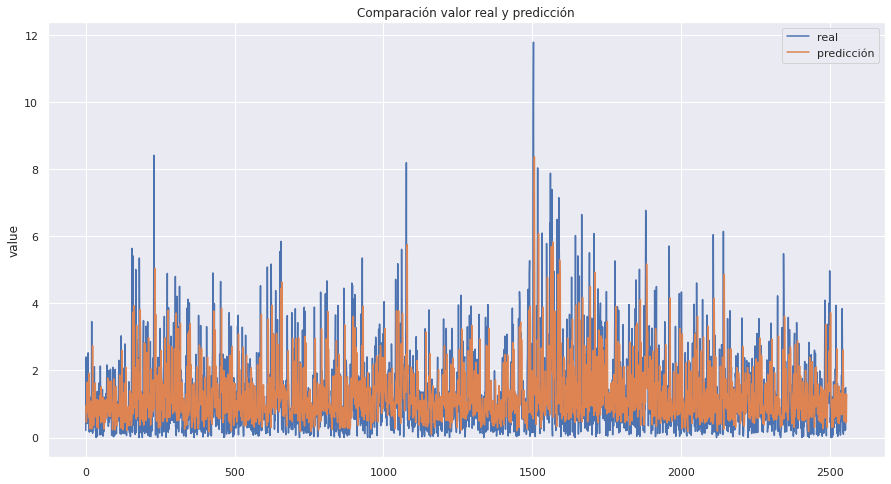

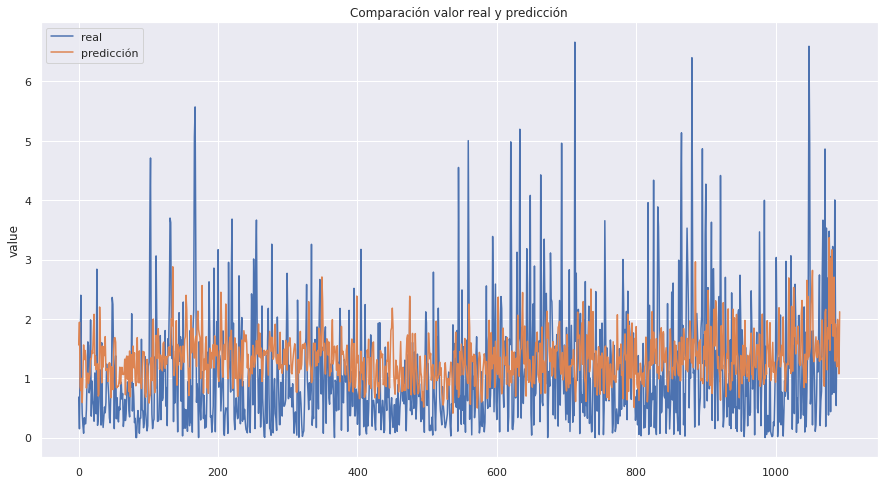

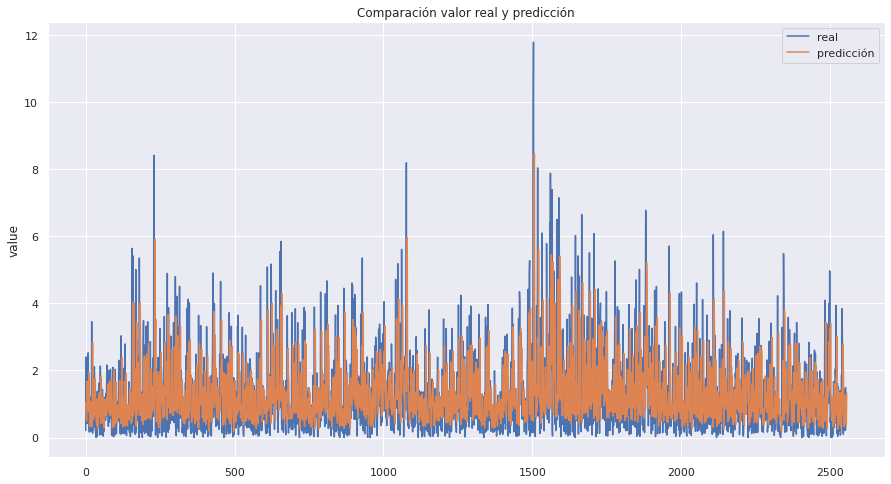

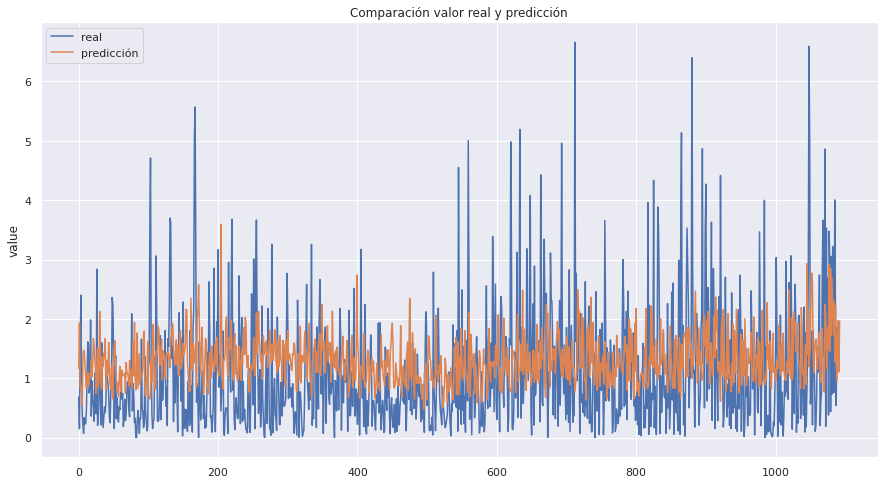

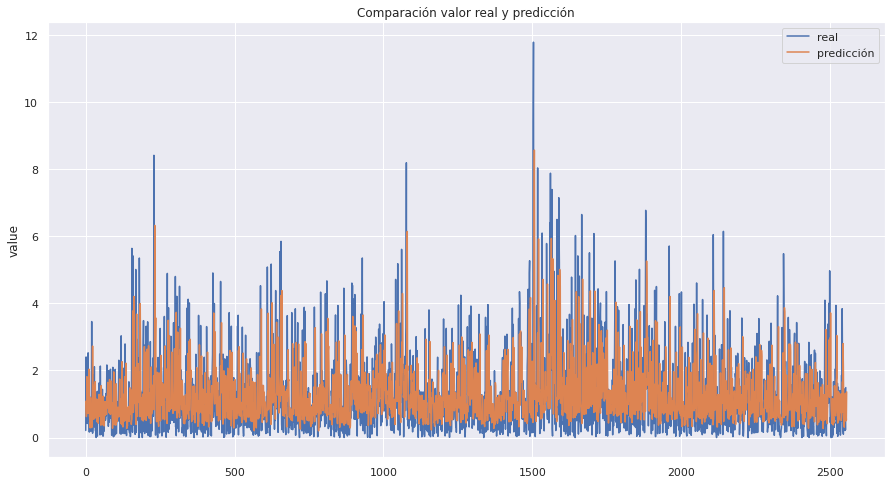

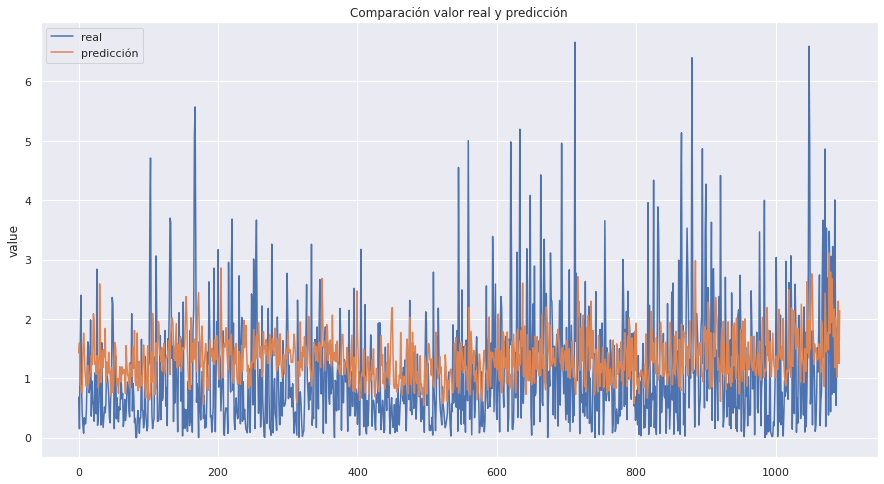

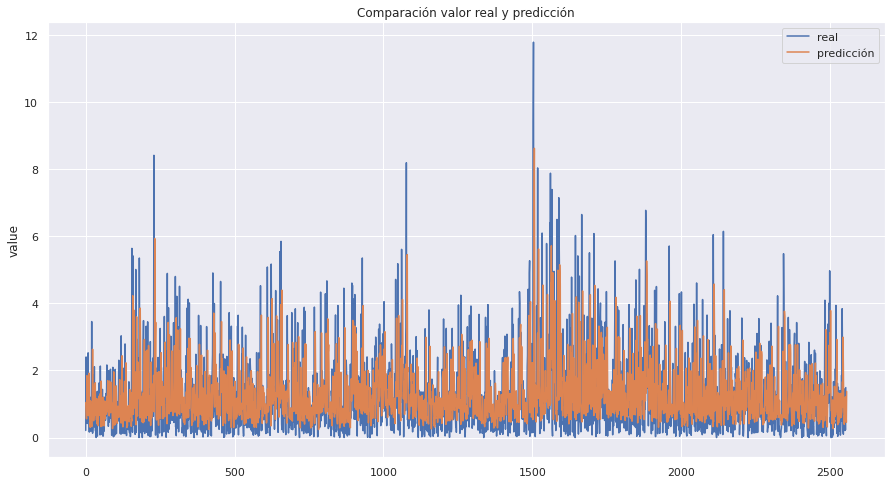

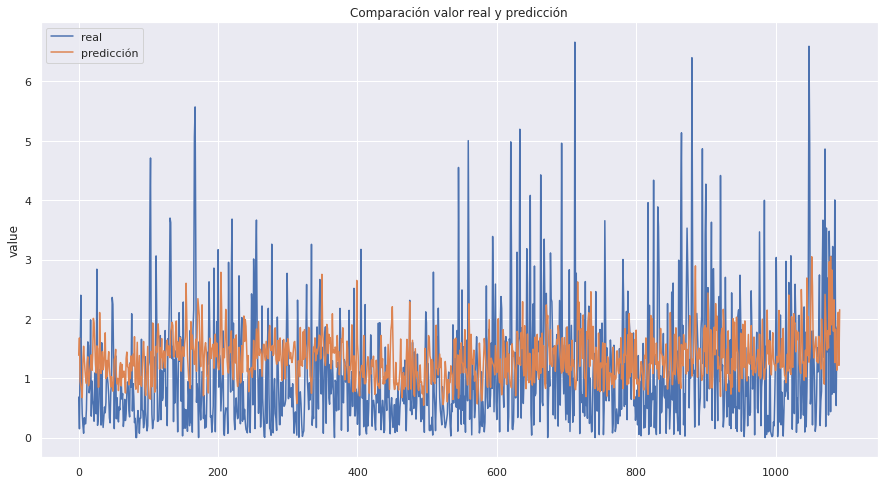

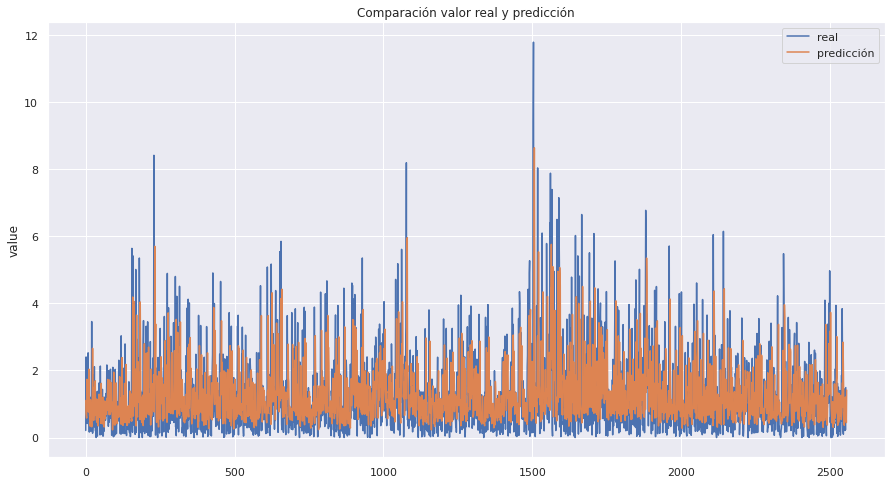

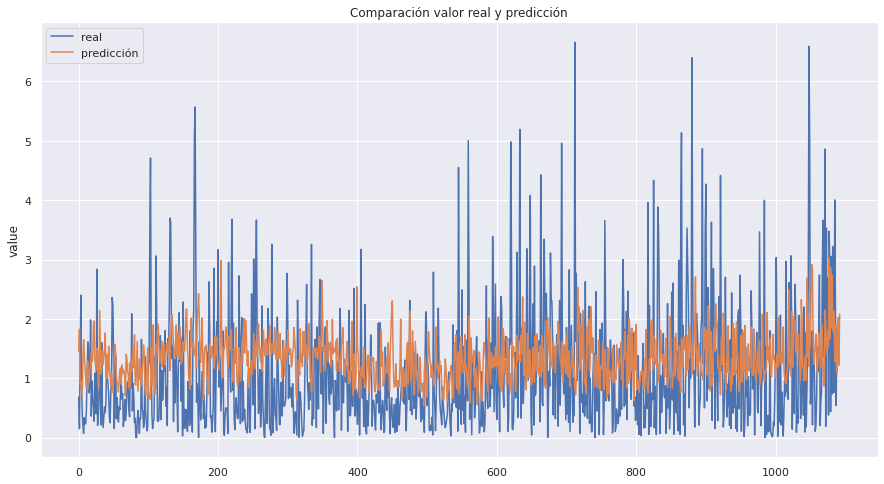

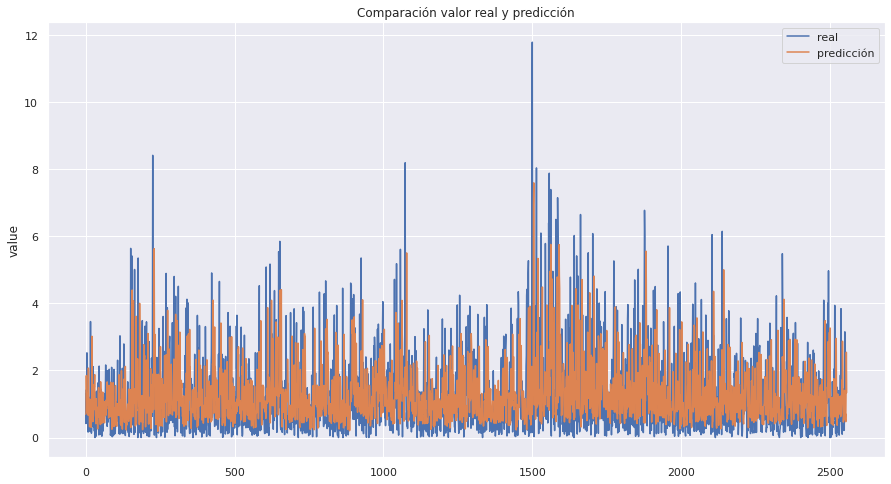

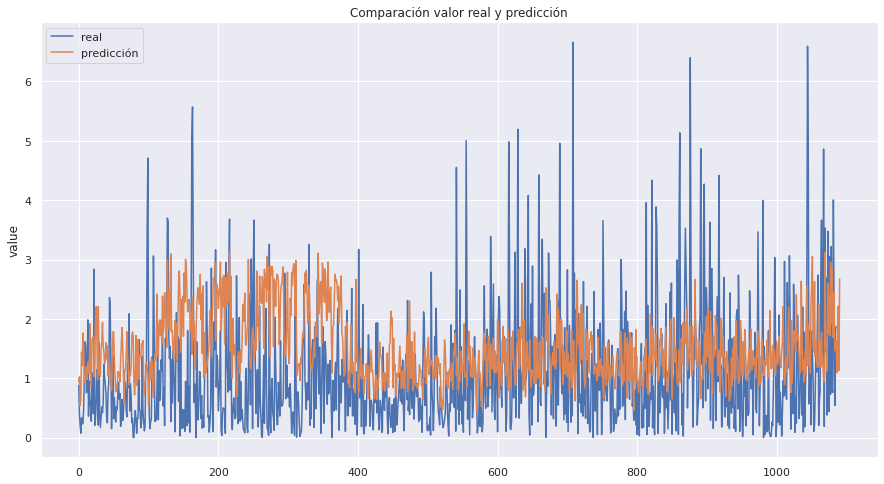

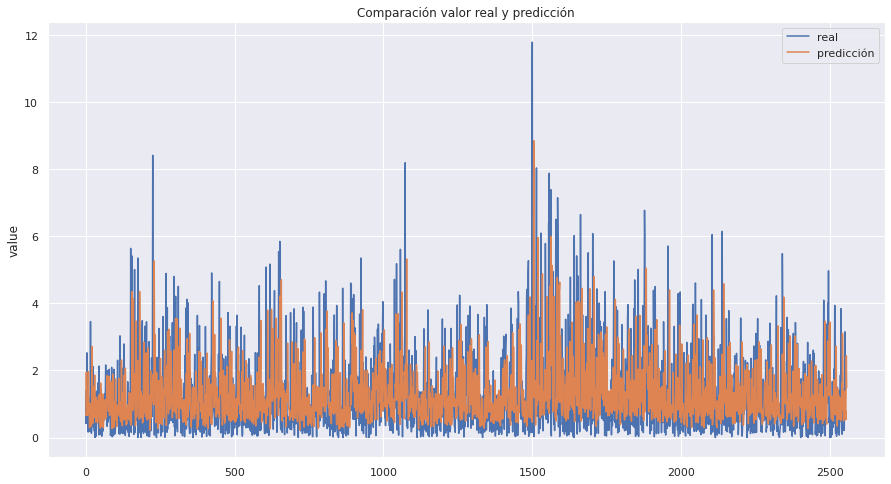

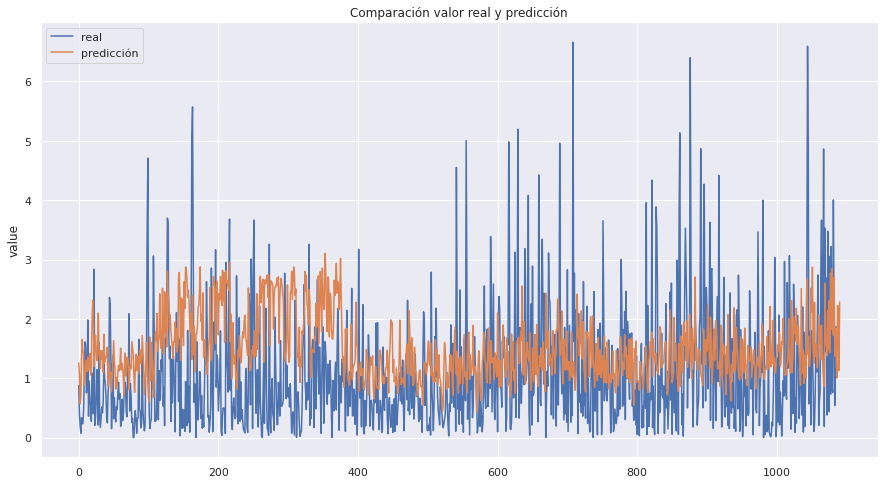

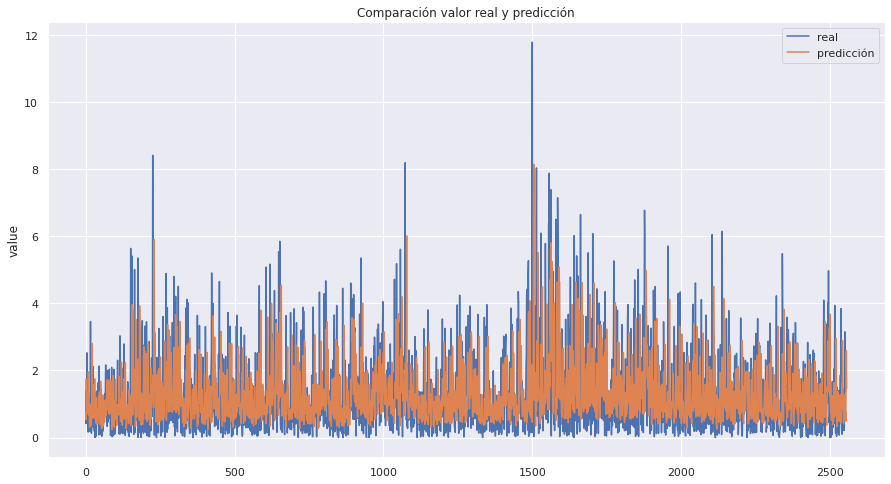

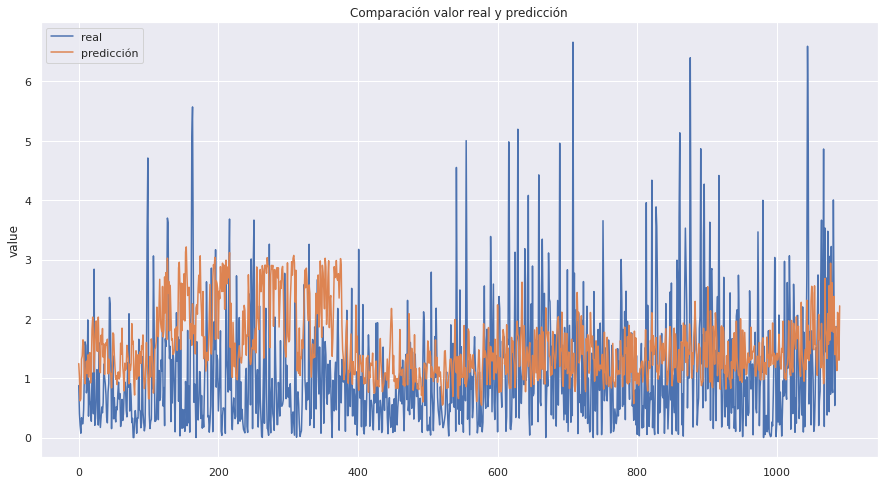

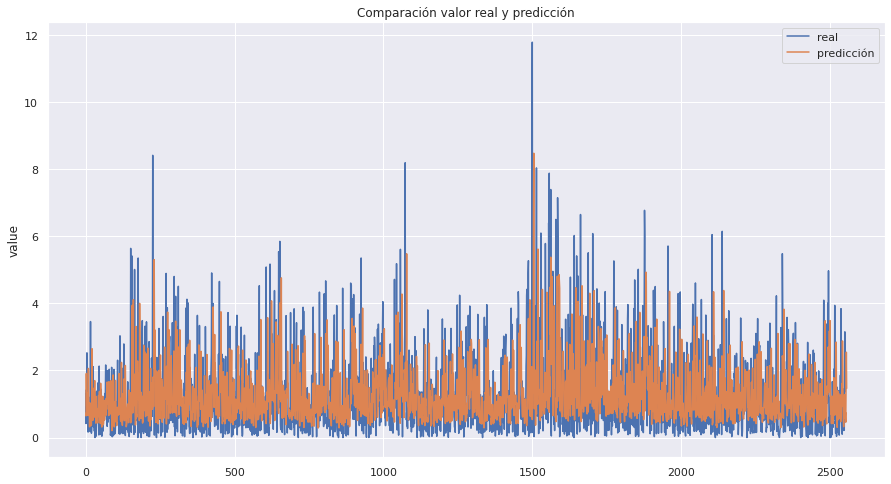

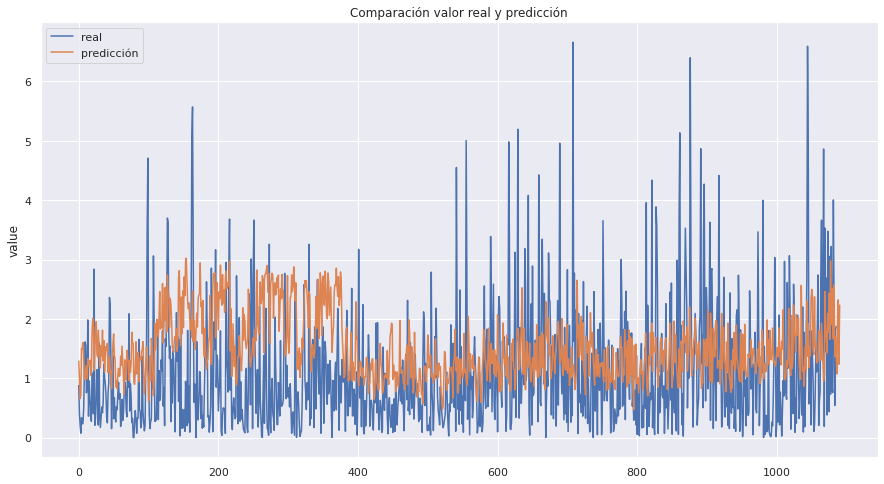

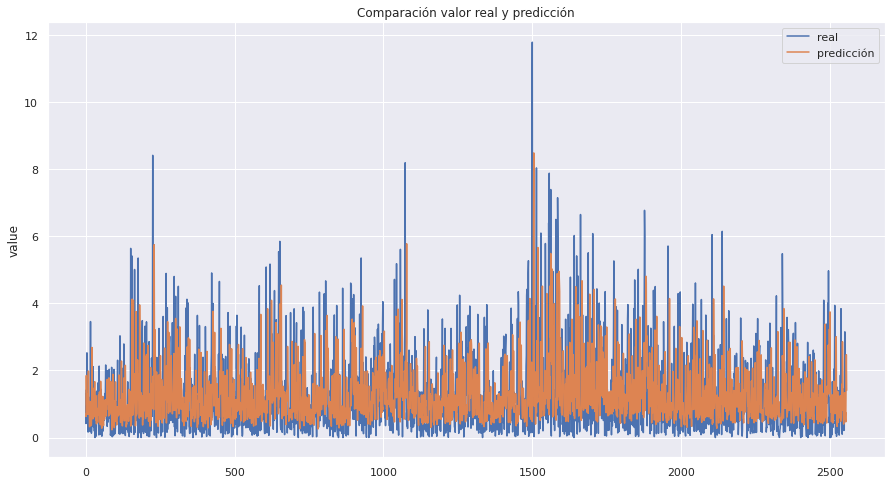

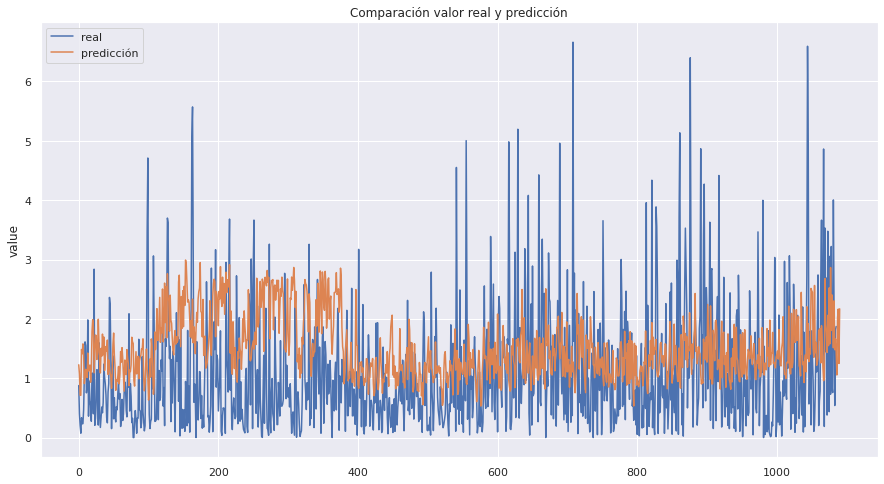

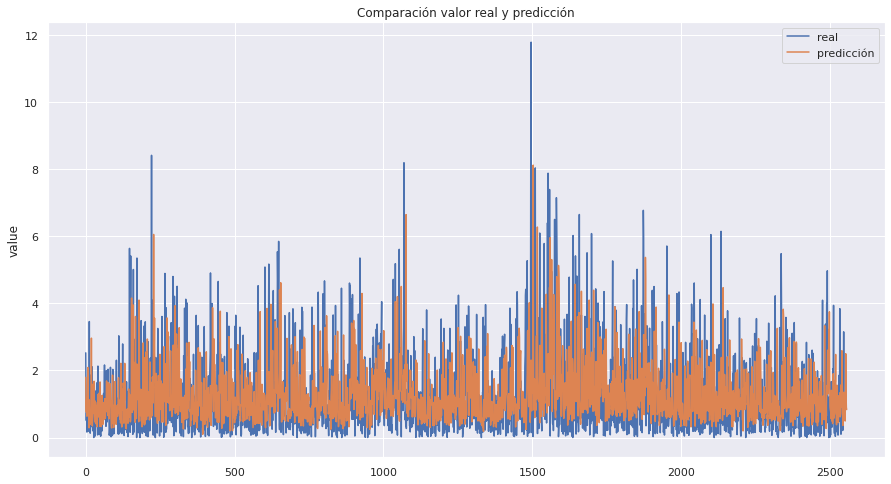

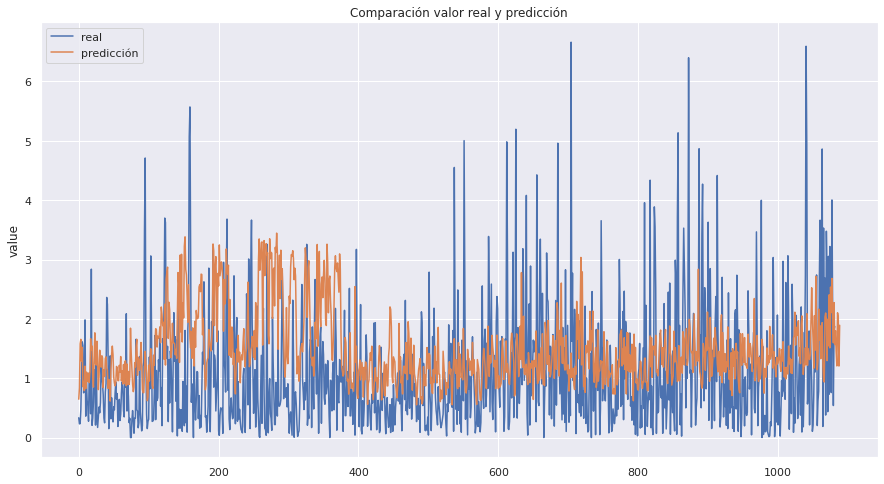

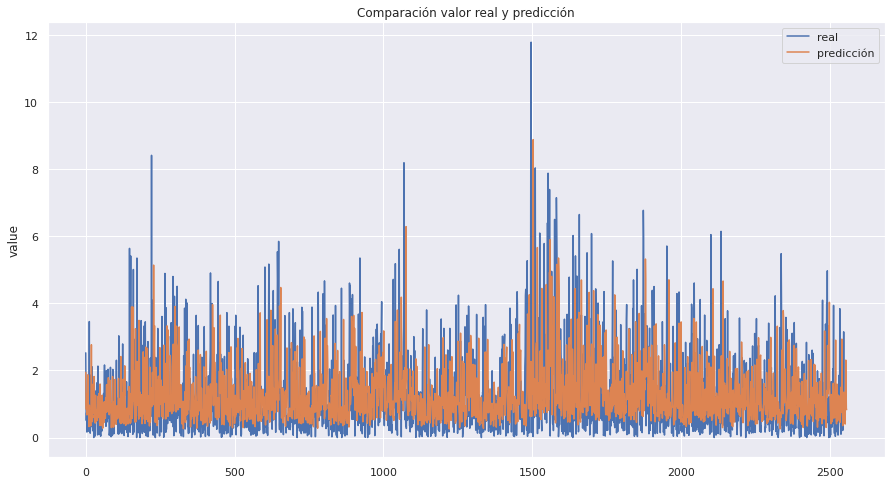

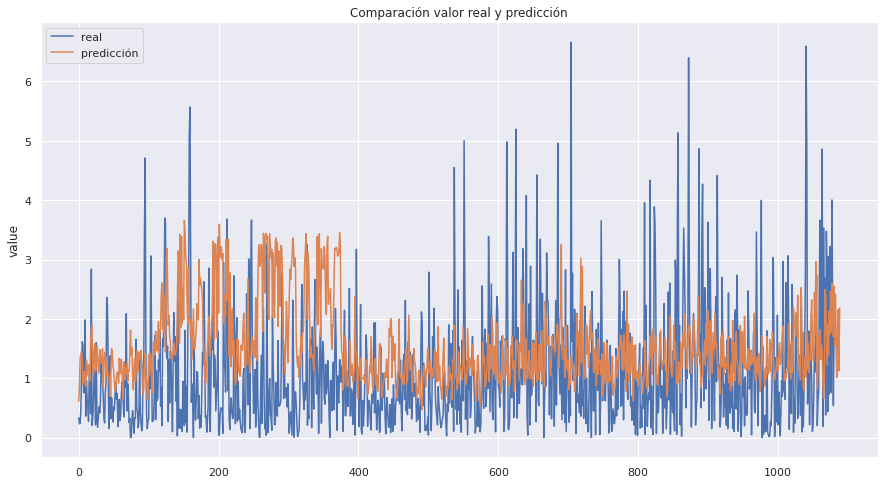

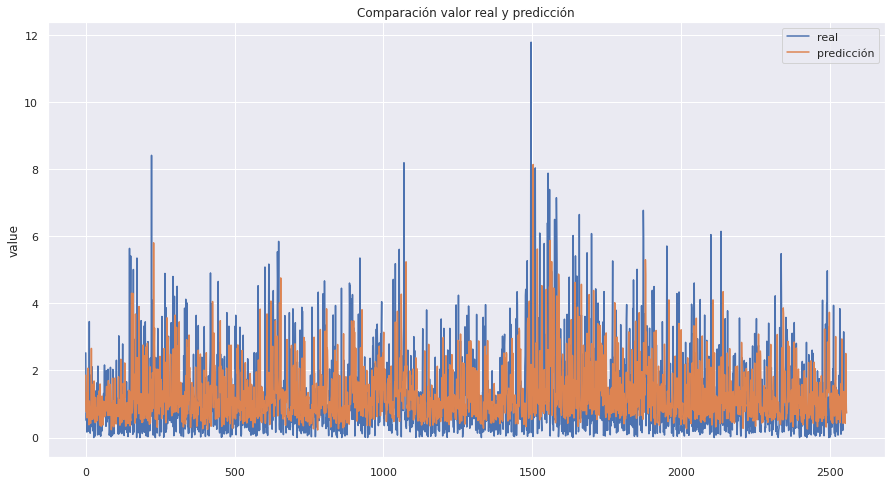

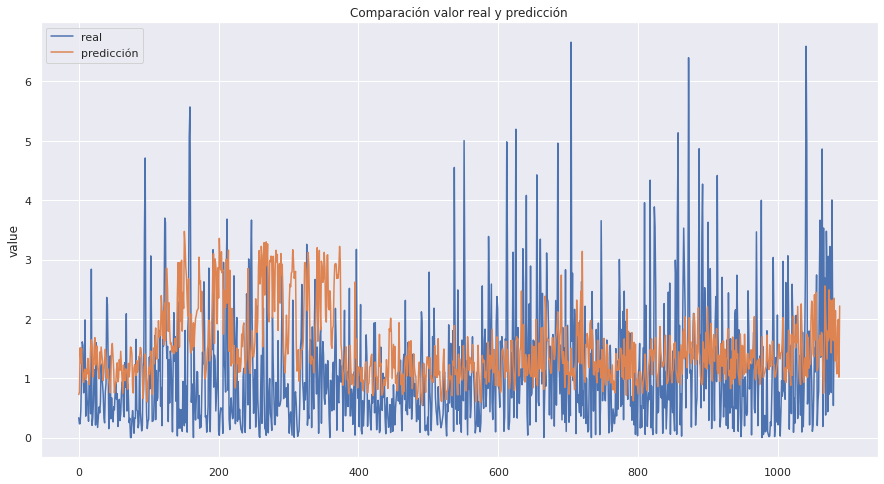

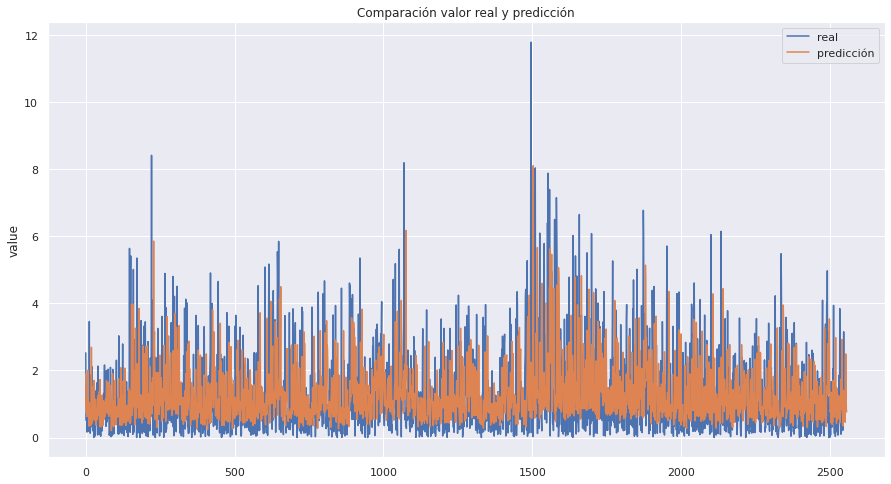

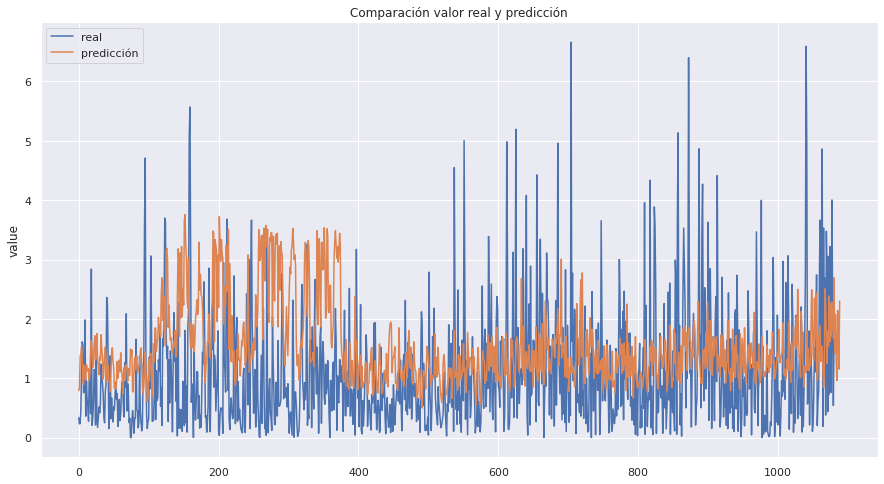

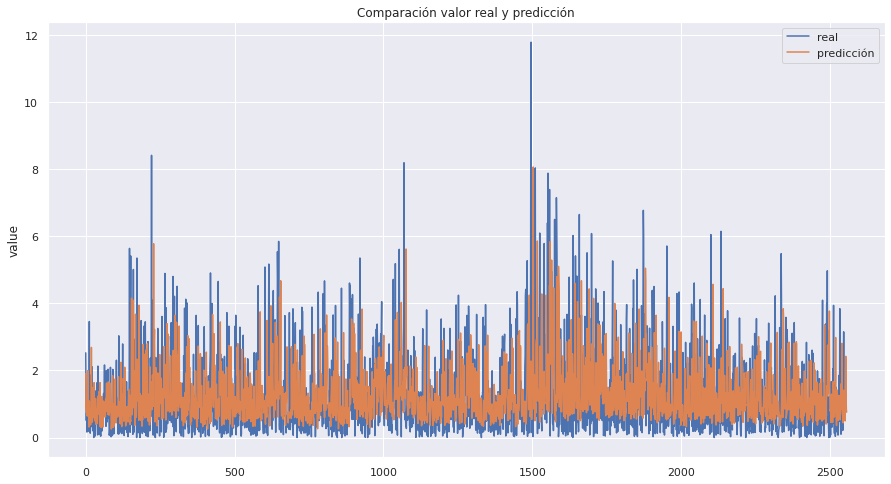

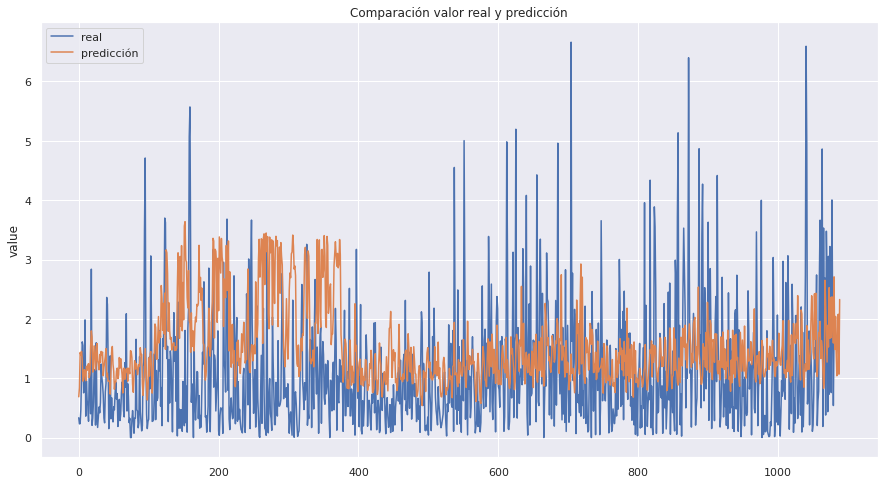

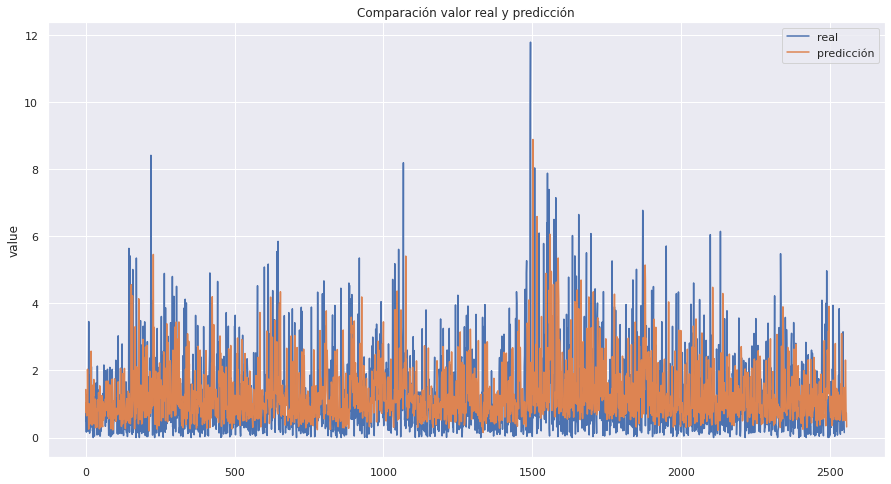

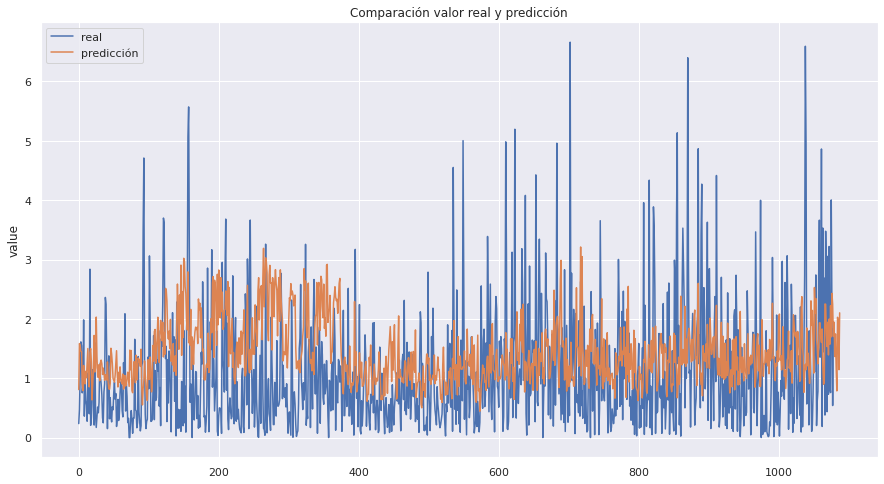

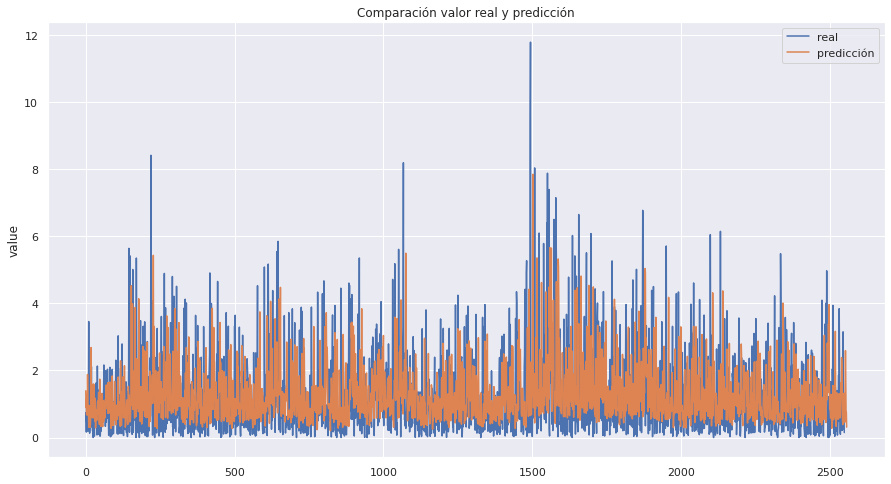

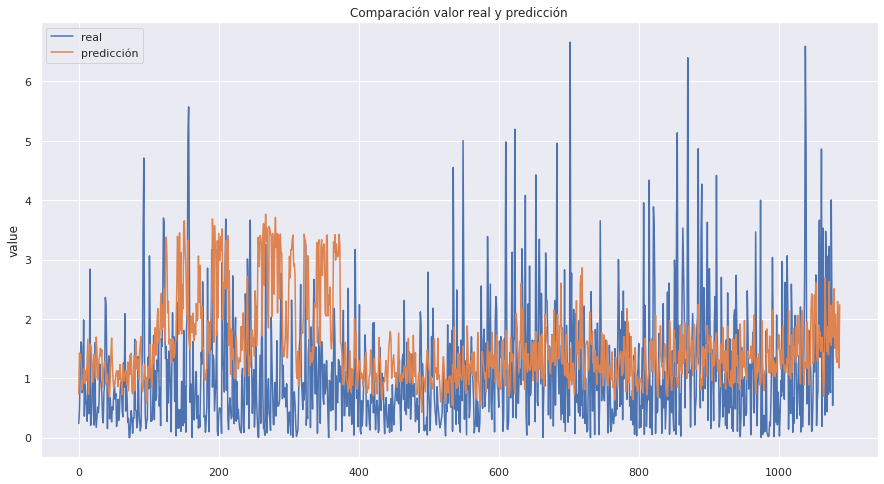

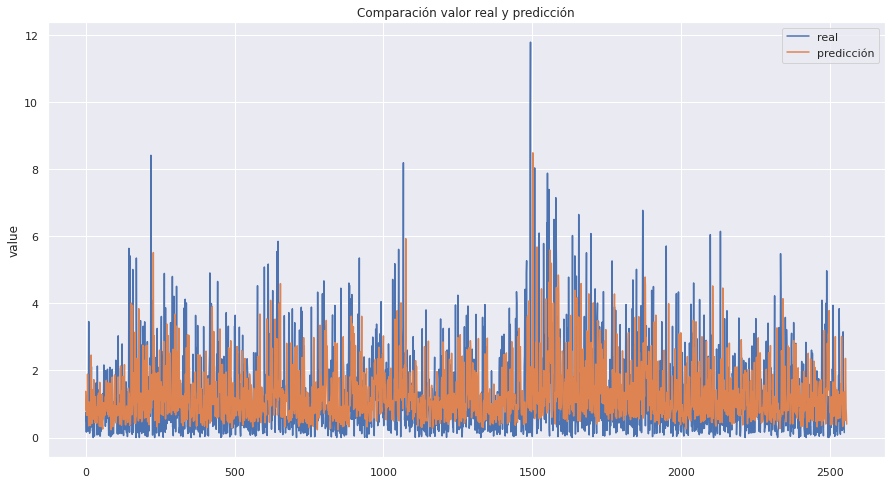

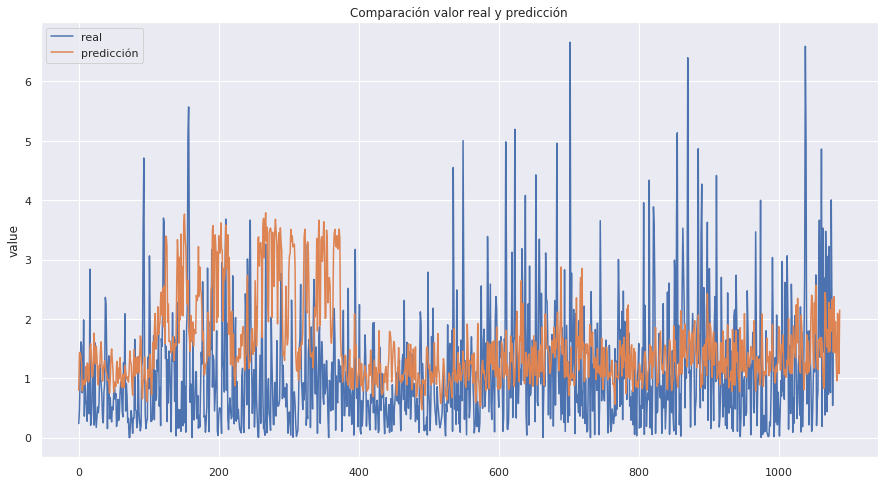

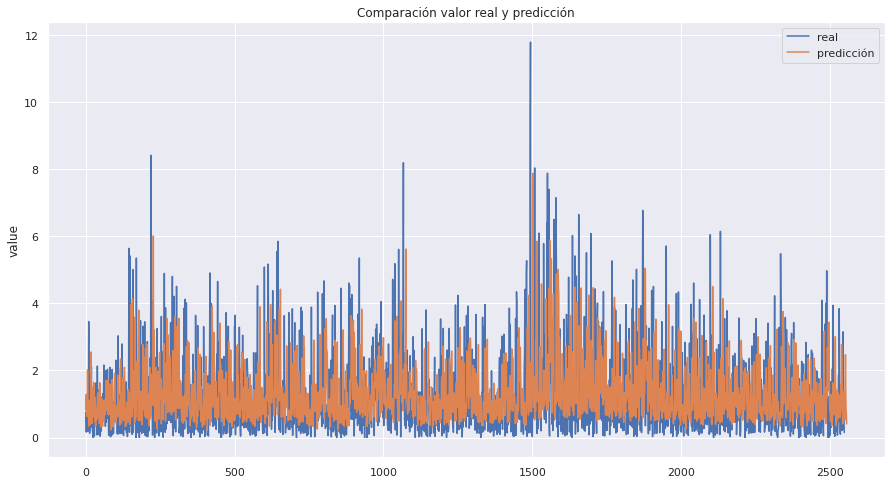

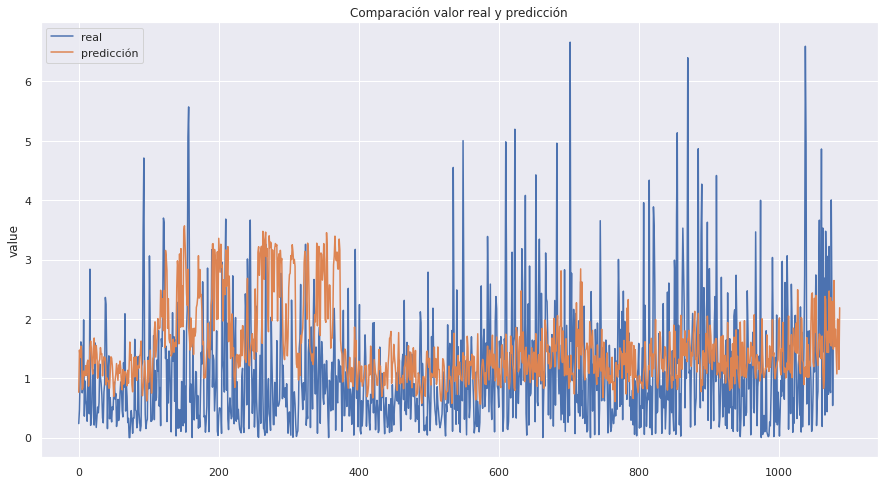

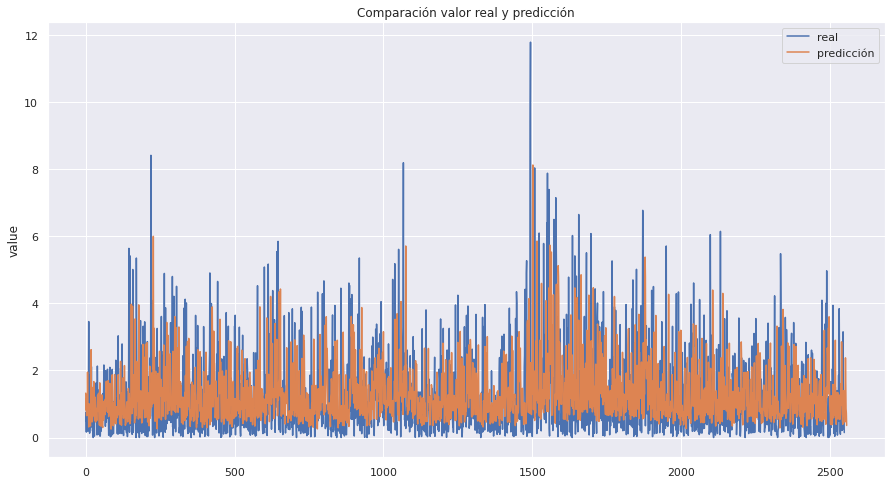

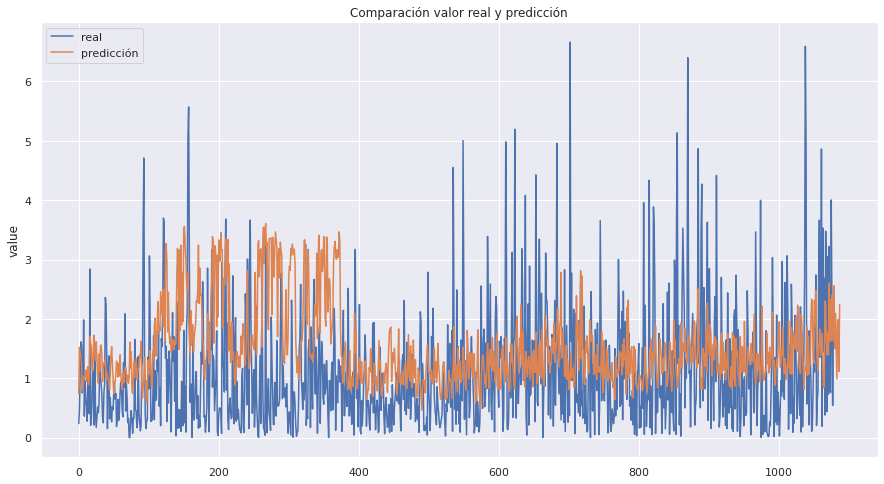

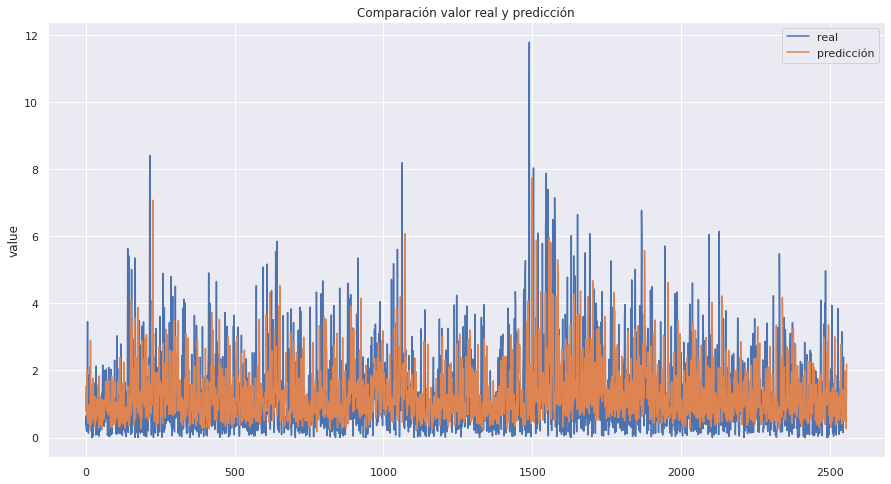

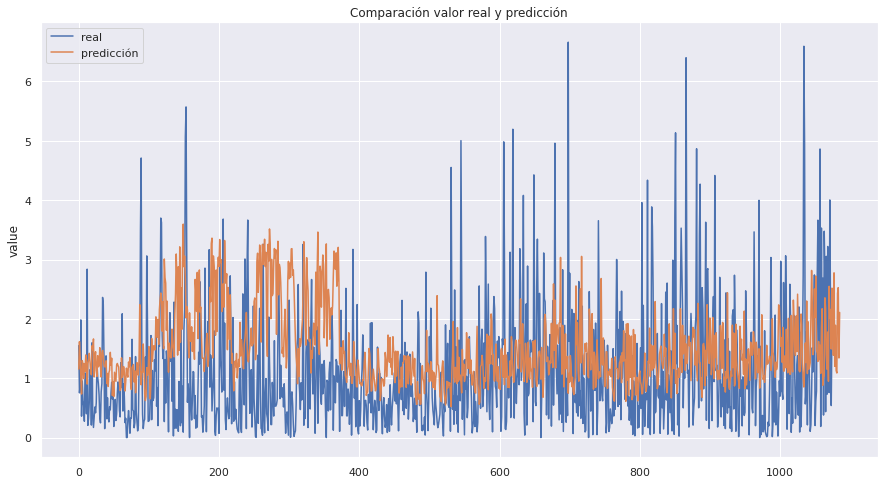

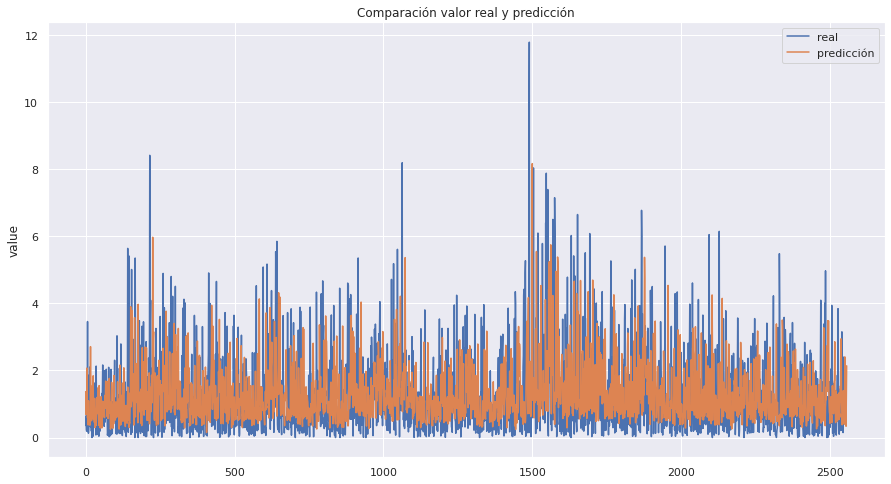

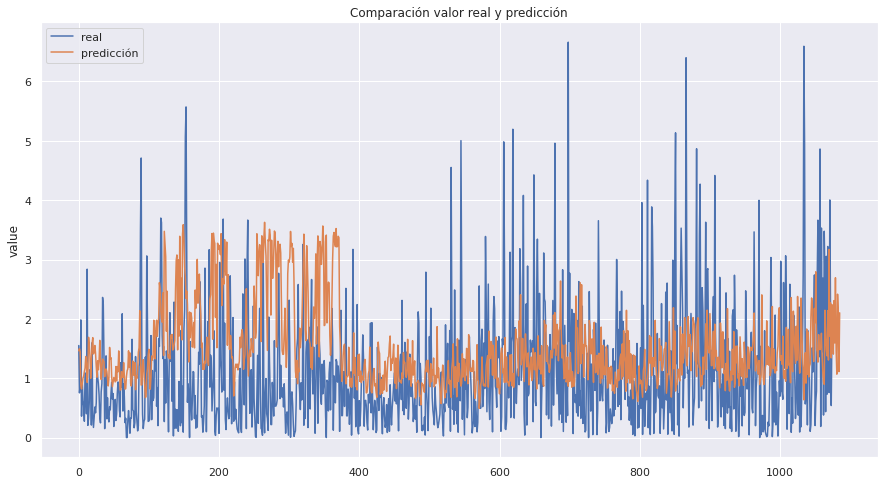

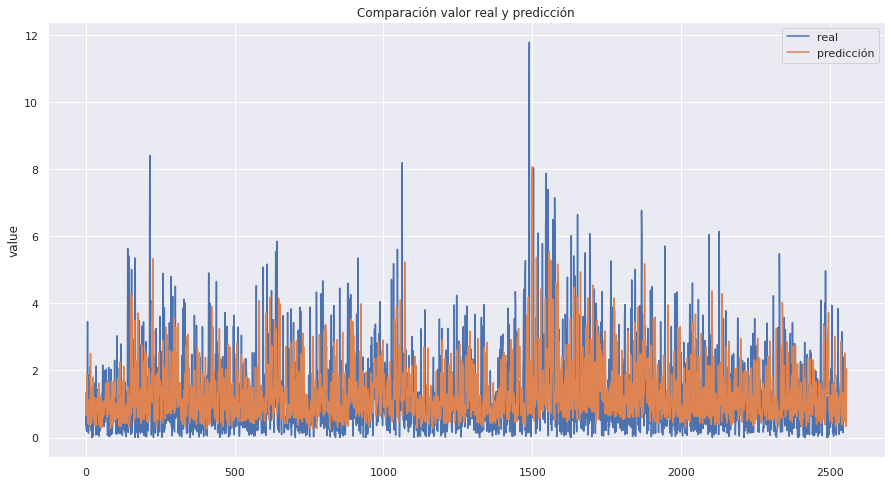

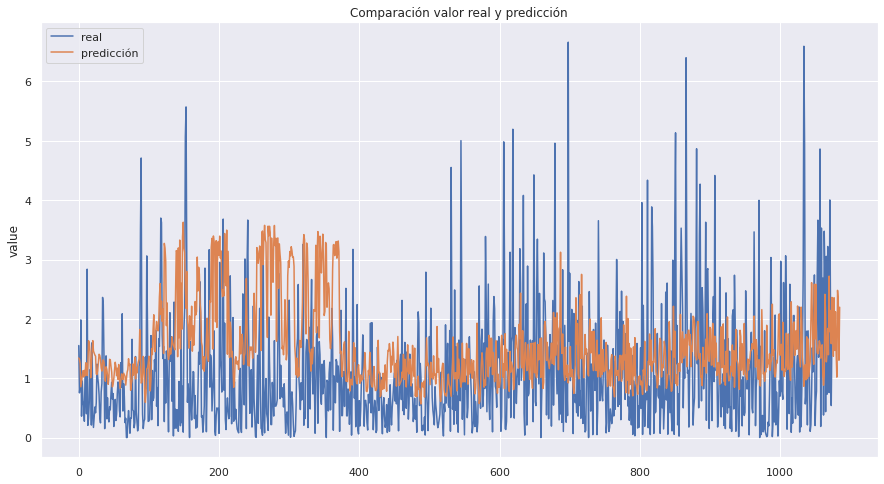

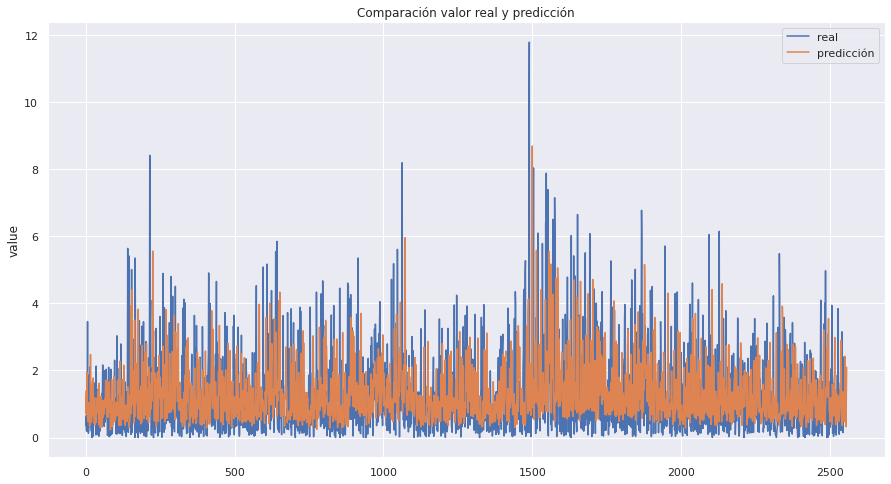

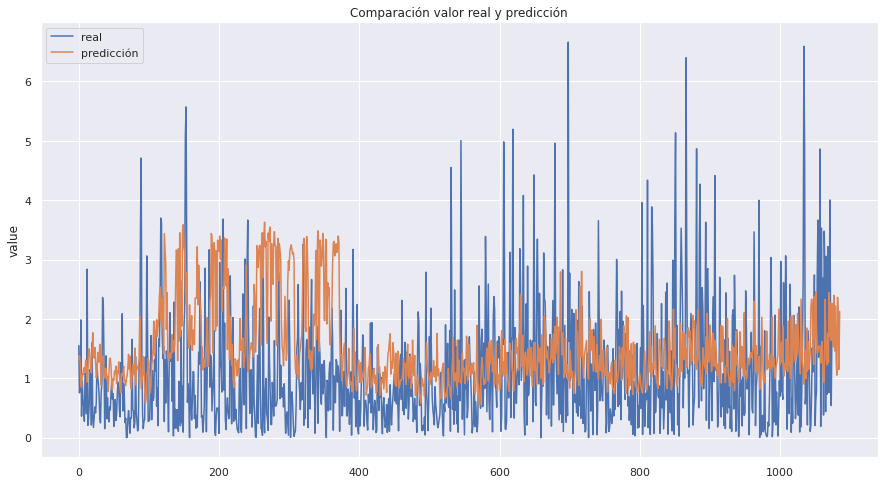

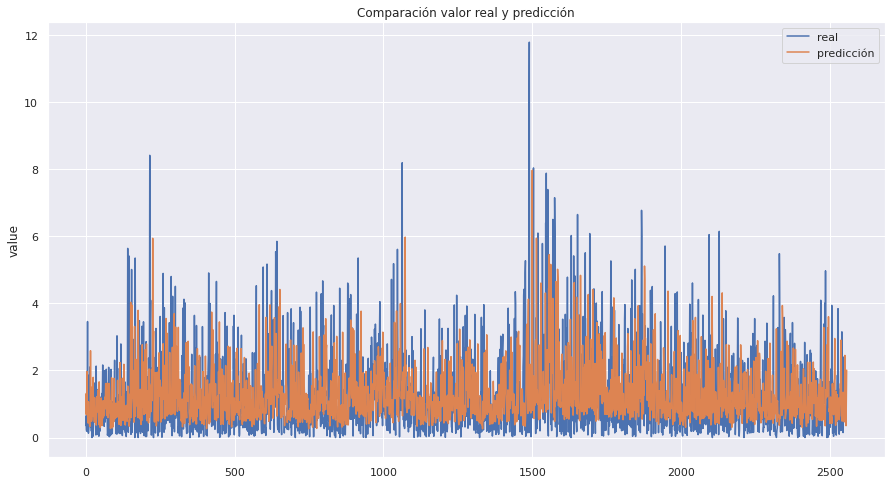

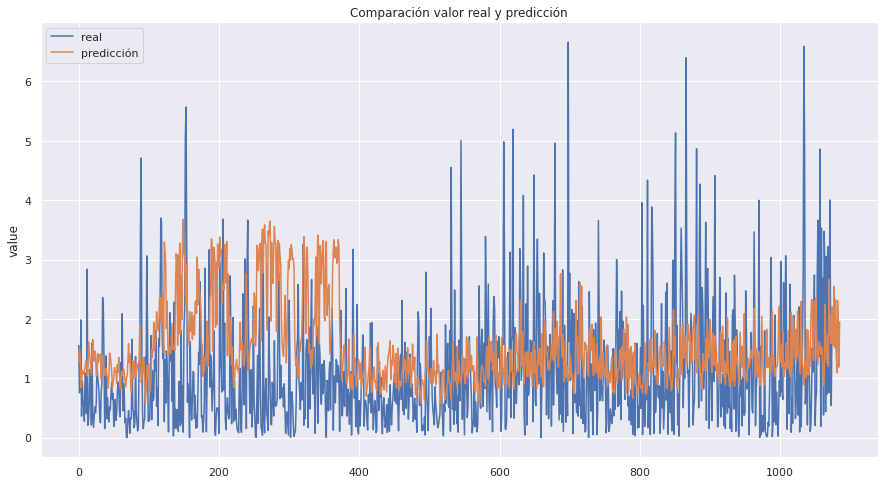

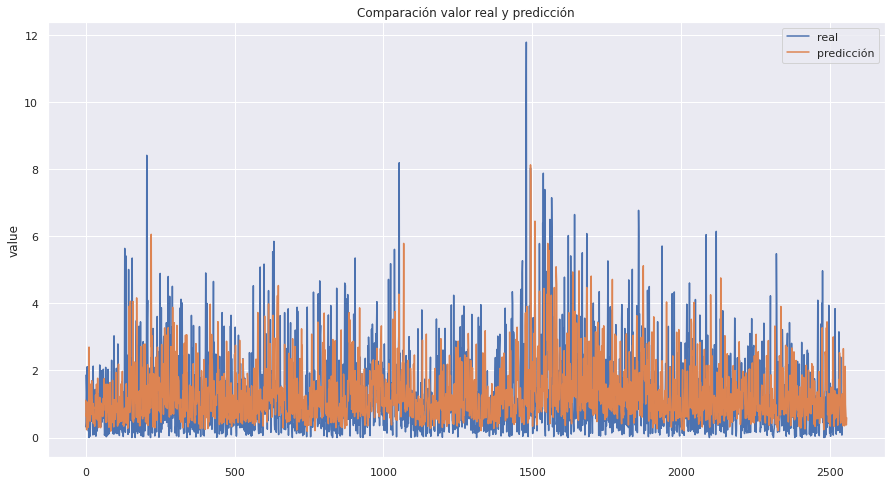

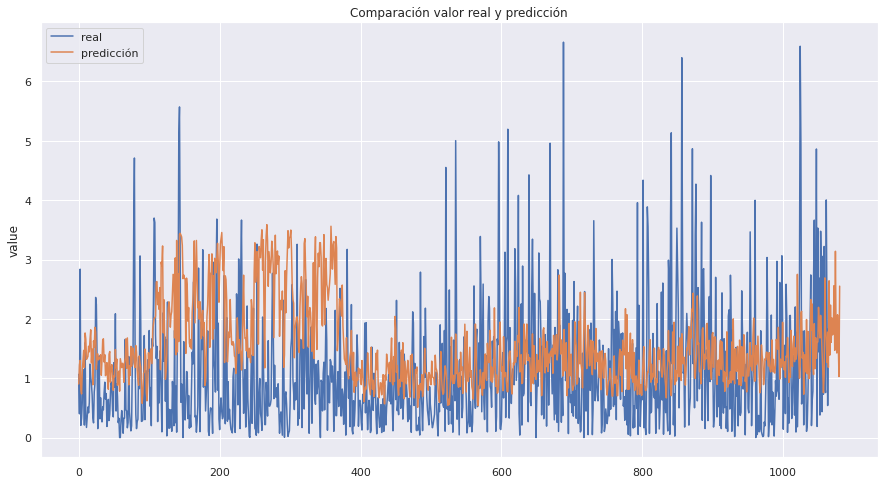

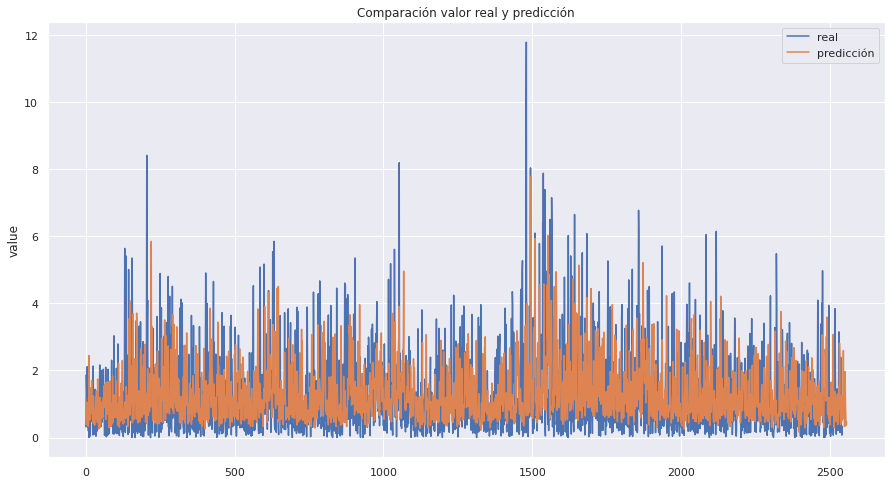

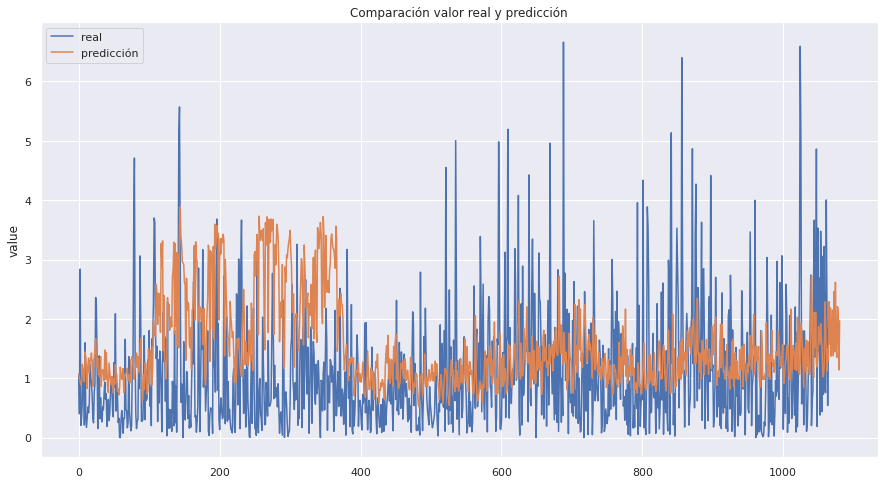

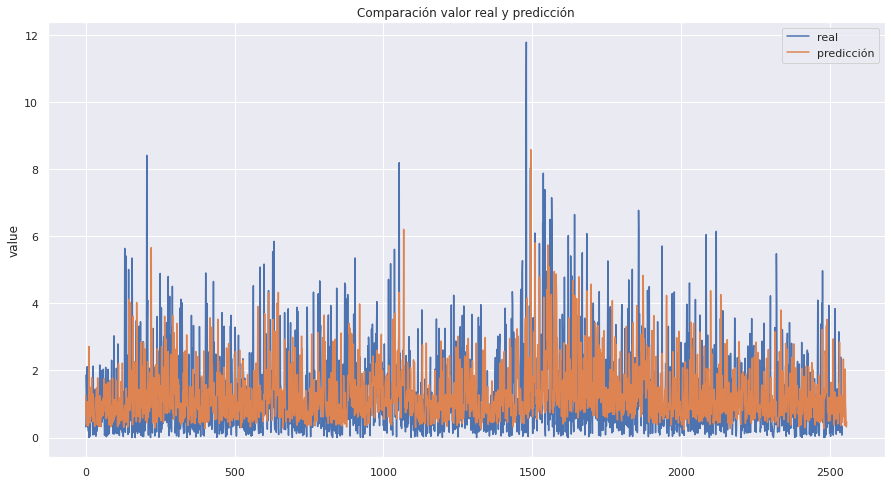

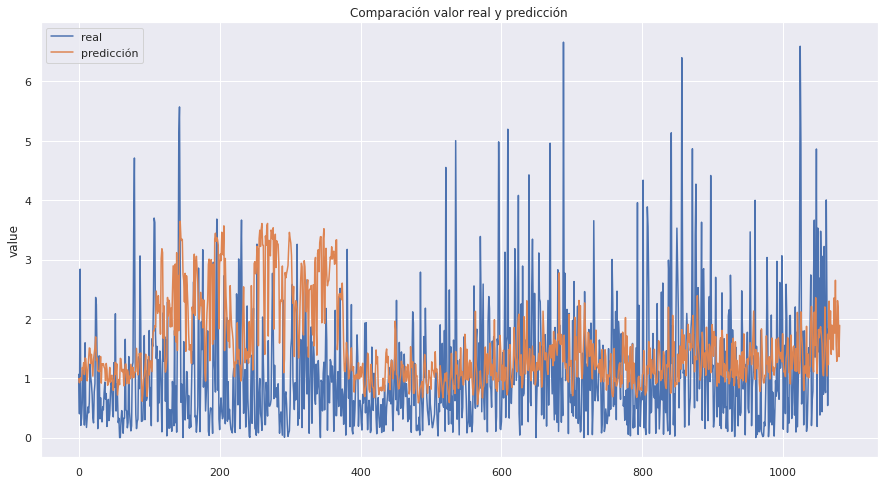

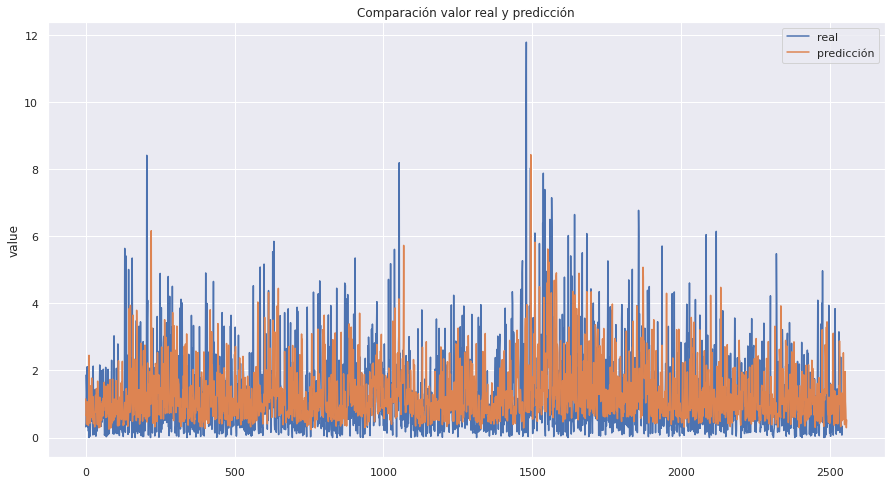

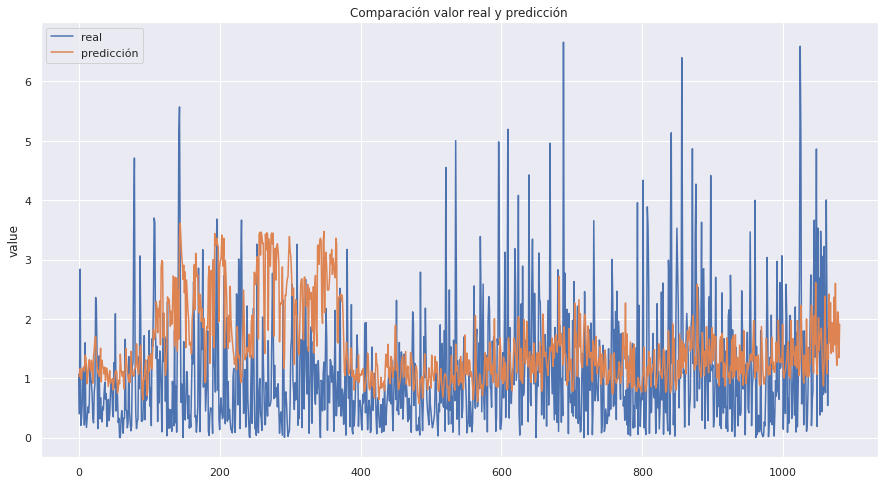

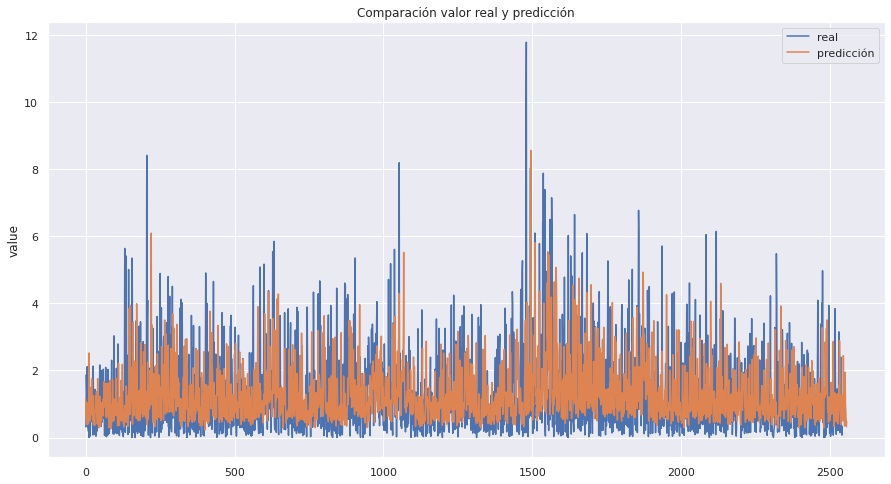

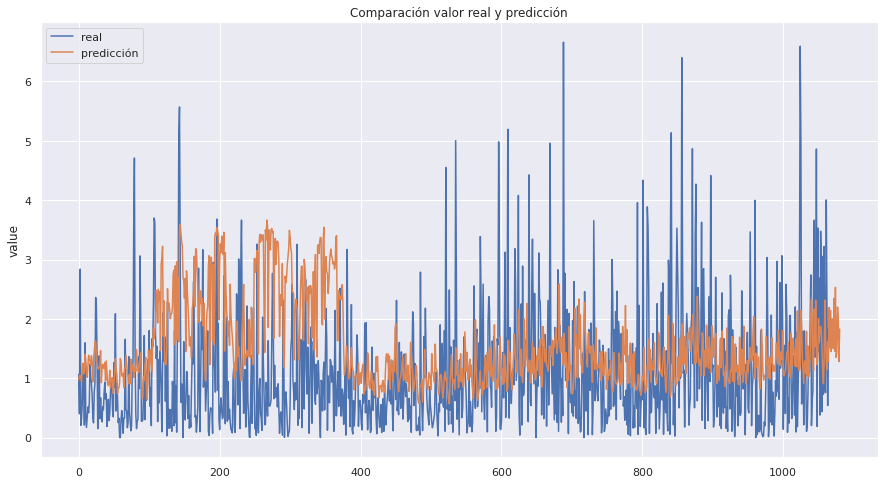

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)